# Crater Detection with RCNN

This repository contains a notebook that demonstrates the implementation of an RCNN (Region-based Convolutional Neural Network) via pre-trained RESNET50_V2 model for detecting craters in satellite images. The project is designed to provide a hands-on experience with applying advanced computer vision techniques.

## Overview

The notebook guides you through the process of setting up the environment, preparing the dataset, defining the RCNN model, training the model, and evaluating its performance. The goal is to detect and localize craters in satellite imagery, which can be crucial for geological studies, planetary science research, and navigation.

## Installation

To run the notebook, you need to have Python installed on your machine, along with Jupyter Notebooks or JupyterLab. You also need to install the following dependencies:

- PyTorch
- torchvision
- Albumentations
- OpenCV
- pycocotools

In [1]:
!python --version

Python 3.9.16


In [2]:
import platform
import subprocess

def install_pytorch():
    os_type = platform.system().lower()
    cuda_compatible = False

    # Attempt to check CUDA availability
    try:
        cuda_check = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
        cuda_compatible = "NVIDIA" in cuda_check.stdout.decode()
    except FileNotFoundError:
        print(f"{os_type.title()} platform detected. CUDA is not compatible or not installed.")

    # Construct the base install command
    base_command = "pip3 install torch torchvision torchaudio"

    # Customize the install command based on OS and CUDA compatibility
    if os_type == "linux" or os_type == "windows":
        if cuda_compatible:
            install_command = f"{base_command} --index-url https://download.pytorch.org/whl/cu118"
        else:
            print("CUDA-compatible GPU not detected. Installing CPU-only version of PyTorch.")
            install_command = f"{base_command} --index-url https://download.pytorch.org/whl/cpu"
    elif os_type == "darwin":  # macOS
        print("macOS detected. Installing the default version of PyTorch (CPU-only).")
        install_command = base_command
    else:
        raise ValueError(f"Unsupported OS: {os_type}")

    # Execute the install command
    print(f"Executing: {install_command}")
    try:
        subprocess.run(install_command.split(), check=True)
    except subprocess.CalledProcessError as e:
        print(f"Failed to install PyTorch: {e}")

# Example usage
install_pytorch()

Darwin platform detected. CUDA is not compatible or not installed.
macOS detected. Installing the default version of PyTorch (CPU-only).
Executing: pip3 install torch torchvision torchaudio
Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.2.0-cp39-none-macosx_11_0_arm64.whl (59.7 MB)
  Using cached torchvision-0.17.0-cp39-cp39-macosx_11_0_arm64.whl (1.6 MB)
  Using cached torchaudio-2.2.0-cp39-cp39-macosx_11_0_arm64.whl (1.8 MB)
  Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
  Using cached typing_extensions-4.9.0-py3-none-any.whl (32 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:

# Clone the torchvision repository and checkout the specified version
!git clone https://github.com/pytorch/vision.git
!cd vision && git checkout v0.17.0

# Copy necessary files from the cloned repository
!cp -f ./vision/references/detection/utils.py ./
!cp -f ./vision/references/detection/transforms.py ./
!cp -f ./vision/references/detection/coco_eval.py ./
!cp -f ./vision/references/detection/engine.py ./
!cp -f ./vision/references/detection/coco_utils.py ./

# Install the required Python packages
!pip install -r requirements.txt

# Note: The conda install command is typically used in a Conda environment. 
# If you're using Conda, you can install PyTorch, torchvision, and torchaudio with the following command:
# !conda install pytorch::pytorch torchvision torchaudio -c pytorch -y
    

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at b2383d4475 [RELEASE-ONLY CHANGES] [Cherry-pick for 0.17] CI fix - Use pytest<8 in unittest jobs (#8240)
  Cloning https://github.com/cocodataset/cocoapi.git to /private/var/folders/vj/cdvpct_s1_x4kn8_l3gt2cl40000gp/T/pip-req-build-pwtwrwiz
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /private/var/folders/vj/cdvpct_s1_x4kn8_l3gt2cl40000gp/T/pip-req-build-pwtwrwiz
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


## Importing Essential Libraries

In this section, we import crucial Python libraries such as PyTorch for neural network operations, OpenCV for image processing, matplotlib for visualization, and others necessary for the data handling and model training processes.

In [3]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_V2_Weights
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from coco_eval import CocoEvaluator
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random

##Dataset Preparation
This part of the notebook defines the dataset handling mechanism, including loading images, applying transformations, and preparing data loaders for training and validation phases.

The Faster RCNN network, as incorporated from the torchvision package, mandates the inclusion of a __getitem__ method within the class for fetching individual images and their corresponding bounding boxes, alongside a __len__ method to ascertain the dataset's size.

Within the __getitem__ method, I've integrated logic to transform bounding box coordinates from the normalized (x, y, width, height) format to the (xmin, ymin, xmax, ymax) format, which is essential for the Faster RCNN model. This transformation is accomplished through the convert_bbox_format method. To address issues arising from importing empty .txt files associated with certain images, I've implemented a safeguard that generates a placeholder bounding box labeled as class 0 (background).

Subsequently, the "target" dictionary is meticulously assembled, incorporating essential keys such as bounding boxes, labels, and other relevant information required by the model.

In [6]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = [img for img in sorted(os.listdir(os.path.join(self.root, "images")))
                     if not img.startswith('._') and os.path.isfile(os.path.join(self.root, "images", img))]
        self.annots = [annot for annot in sorted(os.listdir(os.path.join(self.root, "labels")))
                       if not annot.startswith('._') and os.path.isfile(os.path.join(self.root, "labels", annot))]
        self.classes = ['Background', 'Crater']
        
    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        print(img_path)  # Check the path here within the method
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
def get_model_bbox(num_classes):
    # Use the v2 weights for the fasterrcnn_resnet50_fpn_v2 model
    if FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT is not None:
        model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    else:
        # Fallback to loading the model without pre-defined weights if DEFAULT is not available
        model = fasterrcnn_resnet50_fpn_v2(pretrained=False)

    # If num_classes is specified, update the classifier to match the number of classes
    if num_classes is not None:
        # Get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # Replace the pre-trained head with a new one
        model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model
    return model

def get_transform(train):
    # Define transformations
    if train:
        # Training transformations
        return A.Compose([
            # Add any other transformations here
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=['labels']))
    else:
        # Validation/Testing transformations
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

def reset_weights(m):
    # Function to reset model weights
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [8]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
dataset = CraterDataset('./train/', get_transform(train=True))

./train/images/mars_crater--9-_jpg.rf.64378015a647ef92689e24ea103644cd.jpg


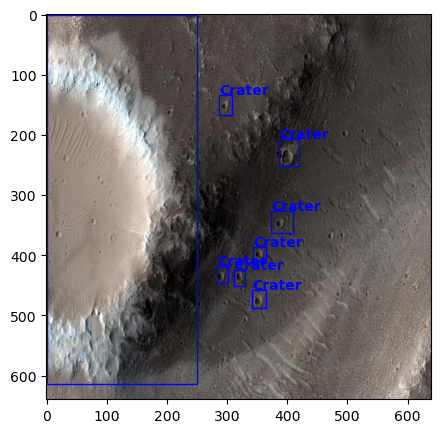

./train/images/mars_crater--69-_jpg.rf.8677e1c58b60bd19c197032d3e749cda.jpg


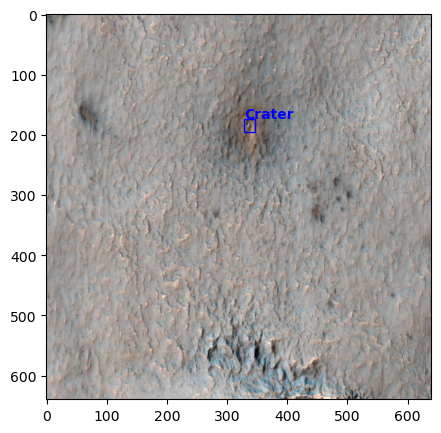

./train/images/mars_crater--24-_jpg.rf.4614bb6844fda70ea8a3b4f515cb7e8f.jpg


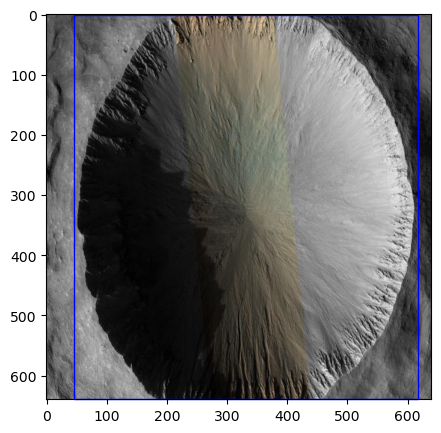

In [11]:
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

In this project, we employed the Faster RCNN model with a ResNet50 backbone pre-trained on the COCO dataset. The model's original ROI head, pre-trained for general object detection tasks, was replaced with a new head that is uninitialized and ready to be trained on our specific dataset.

During the initial phase of the project, various backbones were evaluated (e.g., mobilenet_v3_large_fpn), and we opted to utilize the resnet50_fpn backbone_v2. This decision was made to ensure compatibility and stability.

The data augmentation strategy for this project was defined using the get_transform function. Unlike the default transformation utilities provided by torchvision, which necessitate manual adjustment of bounding box coordinates for each transformation, we chose to integrate Albumentations. This library simplifies the process by automatically managing bounding box adjustments during augmentation. Interestingly, our experimentation revealed that omitting data augmentation yielded superior results during the validation phase. Should augmentation be deemed necessary, it is advisable to employ the min_visibility parameter. This parameter sets a visibility threshold, below which bounding boxes are excluded if their area is significantly reduced post-augmentation.

An exploration into reinitializing the model's trainable weights was conducted using a reset_weights function. Although this approach was briefly tested, it became evident that substantial improvements over the pre-trained model would require a more extensive dataset and a longer training duration.



The challenge of working with a limited dataset is that assessing the trained model's performance on a validation set, whether manually or randomly selected, can be unreliable. It's difficult to determine if the chosen validation set is representative or if it harbors any bias in relation to the training data. While larger datasets naturally mitigate this concern through sheer diversity, ensuring unbiased validation in smaller datasets is less straightforward.

To address this issue, I implemented a 5-fold cross-validation strategy. This approach entails dividing the entire dataset into five distinct parts, using each in turn as the validation set while training on the remaining four. The process is repeated five times, each over 50 epochs, allowing for a comprehensive evaluation across different segments of the data. By averaging the metrics obtained from each fold, we gain a more robust and reliable assessment of the model's performance, enhancing our confidence in the effectiveness of chosen hyperparameters and configurations.

In [28]:

def construct_coco_annotations(dataset):
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "Background"}, {"id": 2, "name": "Crater"}]
    }
    annotation_id = 1

    for img_id, img_file in enumerate(dataset.imgs):
        img_path = os.path.join(dataset.root, "images", img_file)
        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        coco_annotations["images"].append({
            "id": img_id,
            "file_name": img_file,
            "width": width,
            "height": height
        })

        annot_file = os.path.join(dataset.root, "labels", dataset.annots[img_id])
        # Check if annot_file is a file before attempting to read it
        if os.path.isfile(annot_file) and os.path.getsize(annot_file) > 0:
            bboxs = np.loadtxt(annot_file, ndmin=2)
            for bbox in bboxs:
                class_id, x_center, y_center, bbox_width, bbox_height = bbox
                x_min = (x_center - bbox_width / 2) * width
                y_min = (y_center - bbox_height / 2) * height
                width_bbox = bbox_width * width
                height_bbox = bbox_height * height

                coco_annotations["annotations"].append({
                    "id": annotation_id,
                    "image_id": img_id,
                    "category_id": int(class_id) + 1,
                    "bbox": [x_min, y_min, width_bbox, height_bbox],
                    "area": width_bbox * height_bbox,
                    "iscrowd": 0
                })
                annotation_id += 1

    return coco_annotations

def evaluate_with_coco_style(model, data_loader, dataset, device='cpu'):
    model.eval()
    coco_results = []

    # Construct in-memory COCO-style annotations
    coco_annotations = construct_coco_annotations(dataset)
    coco_gt = COCO()
    coco_gt.dataset = coco_annotations
    coco_gt.createIndex()

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            predictions = model(images)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

k_folds = 5
num_epochs = 50


# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('./train', get_transform(train=True))
dataset_val = CraterDataset('./train', get_transform(train=False))


# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset_subset, batch_size=8, shuffle=True, num_workers=0,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_bbox(num_classes)
    
    #model.apply(reset_weights) # Check if beneficial
    
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,  # Check if beneficial
                                momentum=0.9, weight_decay=0)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=10,
                                                    gamma=0.1)
    
    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
    evaluate_with_coco_style(model, data_loader_val, dataset, device=device)

--------------------------------
FOLD 0
--------------------------------
./train/images/01_png.rf.4d2ebc5ed98ad1e69d667aadbce63d53.jpg
./train/images/mars_crater--88-_jpg.rf.2f3b851dec48a94bfccc6519b4a45859.jpg
./train/images/mars_crater--4-_jpg.rf.b31f215c27d917bdb7c7c545db2bc36b.jpg
./train/images/017_png.rf.1504c0d3ecbf20af6bc5114ca197a0dd.jpg
./train/images/mars_crater--9-_jpg.rf.64378015a647ef92689e24ea103644cd.jpg
./train/images/mars_crater--77-_jpg.rf.64732a16676a6c3222f67571cf1d6618.jpg
./train/images/mars_crater--94-_jpg.rf.a1d59711147871b0498b03c2042c7b56.jpg
./train/images/mars_crater--37-_jpg.rf.c2a35d9de333416eb4d6d8f0d6b3310a.jpg
Epoch: [0]  [0/7]  eta: 0:03:47  lr: 0.000838  loss: 1.8364 (1.8364)  loss_classifier: 0.8115 (0.8115)  loss_box_reg: 0.3878 (0.3878)  loss_objectness: 0.5737 (0.5737)  loss_rpn_box_reg: 0.0634 (0.0634)  time: 32.4449  data: 0.0325
./train/images/06_png.rf.aaf8c66b9e4d5e99a3dc70bae7f62c07.jpg
./train/images/mars_crater--80-_jpg.rf.55cff0d5b6e2587

In [13]:
num_epochs = 300 
# our dataset has two classes only - background and crater
num_classes = 2


In [32]:
# use our dataset and defined transformations
dataset = CraterDataset('./train', get_transform(train=True))
dataset_test = CraterDataset('./test', get_transform(train=False))

def construct_coco_annotations(dataset):
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "Background"}, {"id": 2, "name": "Crater"}]
    }
    annotation_id = 1

    for img_id, img_file in enumerate(dataset.imgs):
        img_path = os.path.join(dataset.root, "images", img_file)
        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        coco_annotations["images"].append({
            "id": img_id,
            "file_name": img_file,
            "width": width,
            "height": height
        })

        # Assuming annotations are stored in a way that can be processed here
        # This part will need to be adapted based on your actual annotation format

    return coco_annotations

def evaluate_with_coco_style(model, data_loader, dataset, device='cpu'):
    model.eval()
    coco_annotations = construct_coco_annotations(dataset)
    coco_gt = COCO()
    coco_gt.dataset = coco_annotations
    coco_gt.createIndex()

    coco_dt_results = []

    for images, _ in data_loader:  # Assuming targets are not needed for prediction
        images = [img.to(device) for img in images]
        with torch.no_grad():
            predictions = model(images)

        # Debugging: Check the structure of the first prediction
        if len(predictions) > 0:
            print("First prediction structure:", predictions[0])

        for img_id, prediction in enumerate(predictions):
            # Ensure 'prediction' is a dictionary with expected keys
            if isinstance(prediction, dict) and 'labels' in prediction and 'boxes' in prediction and 'scores' in prediction:
                for i in range(len(prediction['labels'])):
                    coco_result = {
                        "image_id": img_id,
                        "category_id": prediction['labels'][i].item(),
                        "bbox": prediction['boxes'][i].cpu().numpy().tolist(),  # Convert to x_min, y_min, width, height format
                        "score": prediction['scores'][i].item()
                    }
                    coco_dt_results.append(coco_result)
            else:
                print("Unexpected prediction format:", prediction)

    if coco_dt_results:
        coco_dt = coco_gt.loadRes(coco_dt_results)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        # Return the COCOeval object containing all evaluation results
        return coco_eval
    else:
        print("No valid predictions to evaluate.")

    
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_bbox(num_classes)

'''
Use this to reset all trainable weights
model.apply(reset_weights)
'''

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,  # Feel free to play with values
                            momentum=0.9, weight_decay=0)

# Defining learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20,
                                                gamma=0.2)


result_mAP = []
best_epoch = None

# Let's train!
for epoch in range(num_epochs):

    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
   # Evaluate on the test dataset and capture the results
    coco_eval = evaluate_with_coco_style(model, data_loader_test, dataset_test, device=device)

    # Check if the evaluation was successful
    if coco_eval:
        # Extract the desired metric from the coco_eval object
        result_mAP.append(coco_eval.stats[1])  # Assuming you want the mAP at IoU=0.5
        # Save the best model so far based on the metric
        if result_mAP[-1] == max(result_mAP):
            best_save_path = f'Crater_bestmodel_epoch{epoch}.pth'
            torch.save(model.state_dict(), best_save_path)
            best_epoch = epoch
            print(f'\n\nModel from epoch {epoch} saved! Result is {max(result_mAP)}\n\n')
    
# Saving the last model
save_path = os.path.join(f'Crater_noaug_sgd_2batch-lastepoch{num_epochs-1}.pth')
torch.save(model.state_dict(), save_path)
print(f'model from last epoch(no.{num_epochs-1}) saved')

./train/images/mars_crater--78-_jpg.rf.d960fe84ae55c6b91be086d8e8a8ed32.jpg
./train/images/02_png.rf.610687947e4c92f77e6462104ec4b924.jpg
./train/images/020_png.rf.ce87f4889d7441275135633392f98ed7.jpg
./train/images/mars_crater--102-_jpg.rf.9cdbcc724e2e7baf5c5c17aed91c769b.jpg
./train/images/mars_crater--9-_jpg.rf.64378015a647ef92689e24ea103644cd.jpg
./train/images/mars_crater--35-_jpg.rf.826bc4b2a3a69c48144834f40d92439f.jpg
./train/images/06_png.rf.aaf8c66b9e4d5e99a3dc70bae7f62c07.jpg
./train/images/mars_crater--36-_jpg.rf.0100a780ad4217b29c2dc9b46deec040.jpg
Epoch: [0]  [ 0/13]  eta: 0:06:18  lr: 0.000421  loss: 2.6974 (2.6974)  loss_classifier: 0.7503 (0.7503)  loss_box_reg: 0.4176 (0.4176)  loss_objectness: 1.3498 (1.3498)  loss_rpn_box_reg: 0.1797 (0.1797)  time: 29.0877  data: 0.0499
./train/images/mars_crater--59-_jpg.rf.4f609e19d4f7f9987f696183edd87e99.jpg
./train/images/mars_crater--20-_jpg.rf.cb4c2603f4a62bbe96328c29cec6d68e.jpg
./train/images/mars_crater--43-_jpg.rf.27ea7a65

In [14]:
dataset_test = CraterDataset('./test', get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

model = get_model_bbox(num_classes)

# load model to evaluate
model.load_state_dict(torch.load(os.path.join(f'Crater_bestmodel_noaug_sgd_8batch-lastepoch{best_epoch}.pth'),map_location=device))
model.to(device)

  
evaluate(model, data_loader_test, device=device)

NameError: name 'best_epoch' is not defined

In [ ]:
# Define colors for bounding boxes
color_inference = np.array([0.0,0.0,255.0])
color_label = np.array([255.0,0.0,0.0])

# Score value thershold for displaying predictions
detection_threshold = 0.7
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0

!mkdir ./results

In [ ]:
for i,data in enumerate(data_loader_test):
    # get the image file name for predictions file name
    image_name = 'image no:' + str(int(data[1][0]['image_id']))
    model_image = data[0][0]
    cv2_image = np.transpose(model_image.numpy()*255,(1, 2, 0)).astype(np.float32)
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR).astype(np.float32)

    # add batch dimension
    model_image = torch.unsqueeze(model_image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(model_image.to(device))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there's detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = np.round(scores[scores >= detection_threshold],2)
        draw_boxes = boxes.copy()


        # draw the bounding boxes and write the class name on top of it
        for j,box in enumerate(draw_boxes):
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_inference, 2)
            cv2.putText(img=cv2_image, text="Crater",
                        org=(int(box[0]), int(box[1] - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference,
                        thickness=1, lineType=cv2.LINE_AA)
            cv2.putText(img=cv2_image, text=str(scores[j]),
                        org=(int(box[0]), int(box[1] + 8)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference,
                        thickness=1, lineType=cv2.LINE_AA)
            
        # add boxes for labels
        for box in data[1][0]['boxes']:
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_label, 2)
            cv2.putText(img=cv2_image, text="Label",
                        org=(int(box[0]), int(box[1] - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_label,
                        thickness=1, lineType=cv2.LINE_AA)           
            

        # set size
        plt.figure(figsize=(10,10))
        plt.axis("off")

        # convert color from CV2 BGR back to RGB
        plt_image = cv2.cvtColor(cv2_image/255.0, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
        plt.show()
        cv2.imwrite(f"./results/{image_name}.jpg", cv2_image)
    print(f"Image {i + 1} done...")
    print('-' * 50)
print('TEST PREDICTIONS COMPLETE')

avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")